In [1]:
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# Create directories for results and figures on Google Drive
results_base_dir = '/content/drive/MyDrive/Colab_Notebooks/Fashion_MNIST/Classification/Baseline_100p/'
figures_base_dir_original = '/content/drive/MyDrive/Colab_Notebooks/Fashion_MNIST/Classification/Baseline_100p/'
import os
os.makedirs(results_base_dir, exist_ok=True)
os.makedirs(figures_base_dir_original, exist_ok=True)

# Set environment variables (optional, adjust if needed)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".9"

# Load packages
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

!pip install ml_collections

import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
import ml_collections
from ml_collections import config_flags
import tensorflow_datasets as tfds
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/Fashion_MNIST/Classification/') # Adjust this path if needed

import input_pipeline_missing_B as input_pipeline_missing
import other
import classifier_CNN_fashion as cla
import train_vae_withCorthog as train
import utils
import train_vae_withCevals as train_evals
from train_vae_withCorthog import _rotate_single_image_with_angle # import the rotation function

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.0 MB/s eta 0:00:00


In [2]:
no_latents1 = 20
no_latents2 = 20
num_epochs = 40

c_flags1 = other.get_config(no_latents1, no_latents2, number_epochs=num_epochs)
ds_builder = tfds.builder('fashion_mnist')
ds_builder.download_and_prepare()

layer_sizes = [392, 512, 512, 10]
layer_sizes_full = [784, 512, 512, 10]
step_size = 0.01

batch_size = 32
n_targets = 10

percentage = 100
number_of_simulations = 5

input_dim = 784
n_targets = 10

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.UECOX6_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.UECOX6_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
#C is orthogonal

results_orth = np.zeros((5,19))
figures_base_dir = os.path.join(figures_base_dir_original, 'C_orth_zerorot_CNN/')

for i in range(number_of_simulations):
    logging.info('Initializing dataset.')
    train_ds, train_labs, val_ds, val_labs = input_pipeline_missing.build_train_val_set(c_flags1.batch_size, ds_builder,40+i, percentage_to_keep=percentage, validation_split_percentage=10)
    test_ds, test_labs = input_pipeline_missing.build_combined_test_set(ds_builder,40+i, percentage_to_keep=percentage)
    full_train_ds, full_train_labs, full_val_ds, full_val_labs = input_pipeline_missing.build_full_train_with_val(ds_builder,40+i, percentage_to_keep=percentage, validation_split_percentage=10)
    logging.info('Initializing model.')

    params_full = cla.init_network_params(input_shape=(input_dim,), key=random.key(i), num_classes=n_targets)

    vae_full_train_res, vae_params, vae_val_res, \
    vae_full_train_cond, vae_val_cond, \
    vae_full_train_loss_metrics, vae_val_loss_metrics, \
    vae_val_mat, vae_val_comparison_image, \
    test_data_for_classifier_unmasked_plus_generated, \
    original_full_train1_for_vae_training, original_full_train2_for_vae_training,\
    vae_test_recon_input_views, vae_test_generated_missing_views, \
    test_ds1, test_ds2, \
    top_view_for_classifier, bottom_view_for_classifier,\
    metrics_val_final_epoch,ll_val, metrics_test,ll_test =  train.train_and_eval_split(c_flags1, train_ds, full_val_ds, test_ds,
                                                                                       full_train_ds,full_val_ds, 20000, 30+i,\
                                                                                       results_dir=results_base_dir,\
                                                                                       figures_dir=figures_base_dir, print_images=True)

    # --- Save the comparison image for this simulation run ---
    # Access the comparison image from the 'result' tuple (it's the 9th element, so index 8)
    utils.save_image(
        vae_val_comparison_image,
        os.path.join(figures_base_dir, f'conditional_generation_Corth_sim_{i+1}_final_epoch.png'),
        nrow=8 # This will arrange the 8 examples horizontally
    )

    au1 = sum(jnp.diag(jnp.cov(jnp.transpose(vae_full_train_res['mean1'])))>0.01)
    au2 = sum(jnp.diag(jnp.cov(jnp.transpose(vae_full_train_res['mean2'])))>0.01)

    # --- CLASSIFIER EVALUATION on VAE-processed TEST DATA ---
    # To Evaluate the already-trained classifier on the test set with randomly masked and generated views.
    # The inputs to class_results_combine should be:
    # test_ds1: vae_test_original_input_views (the original unmasked half)
    # test_ds2: vae_test_original_missing_views (the original masked half, for comparison)
    # recon_test1_from_input: vae_test_recon_input_views (VAE's reconstruction of the provided half)
    # recon_test2_generated: vae_test_generated_missing_views (VAE's generated missing half)

    final_classifier_train_acc, final_classifier_test_acc_original, \
    final_classifier_test_acc_orig_top_gen_bottom, \
    final_classifier_test_acc_gen_top_orig_bottom, \
    final_classifier_test_acc_full_processed = \
    cla.class_results_combine(
        train_ds1=original_full_train1_for_vae_training,
        train_ds2=original_full_train2_for_vae_training,
        train_labs=full_train_labs, # Original labels for the training subset

        # Pass the original top and bottom views
        original_top_view_test=test_ds1, # Assuming test_ds1 is the original top half from input_pipeline
        original_bottom_view_test=test_ds2, # Assuming test_ds2 is the original bottom half from input_pipeline

        # Pass the spatially consistent PROCESSED top and bottom views
        processed_top_view_test=top_view_for_classifier,
        processed_bottom_view_test=bottom_view_for_classifier,

        test_labs=test_labs,

        full_train1=vae_full_train_res['rec_v1'], # Classifier's own "full_train" for its internal train_acc
        full_train2=vae_full_train_res['rec_v2'],
        full_train_labs=full_train_labs,

        params=params_full,
        num_epochs=30,
        batch_num=c_flags1.batch_size,
        end_range=784
    )

    # --- Store Results ---
    # Update results_eval[i,] with the relevant metrics.
    # Make sure results_eval is initialized with enough columns.
    results_orth[i,] = (
    percentage,
    int(len(full_train_ds)),
    int(len(test_ds)),
    num_epochs,
    metrics_val_final_epoch['loss'],
    metrics_val_final_epoch['bce'],
    metrics_val_final_epoch['kld'],
    ll_val,
    float(jnp.mean(metrics_test['loss'])),
    float(jnp.mean(metrics_test['bce'])),
    float(jnp.mean(metrics_test['kld'])),
    float(jnp.mean(ll_test)),
    final_classifier_train_acc[-1], # Classifier's training accuracy on VAE-reconstructed training data
    final_classifier_test_acc_original[-1], # Classifier accuracy on fully original test data
    final_classifier_test_acc_orig_top_gen_bottom[-1], # Classifier accuracy on [VAE_rec_provided_half, original_masked_half]
    final_classifier_test_acc_gen_top_orig_bottom[-1], # Classifier accuracy on [original_provided_half, VAE_gen_missing_half]
    final_classifier_test_acc_full_processed[-1], # Classifier accuracy on [VAE_rec_provided_half, VAE_gen_missing_half]
    au1,
    au2,
    # VAE Test Metrics (from eval_conditional_generation_f)
    #float(jnp.mean(vae_test_metrics['loss'])),
    #float(jnp.mean(vae_test_metrics['bce'])),
    #float(jnp.mean(vae_test_metrics['kld'])),
    #float(jnp.mean(vae_test_ll))
    )

    with open(os.path.join(results_base_dir, 'orthogonal_results.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerows(results_orth)

print(f"Saved conditional generation example for simulation run {i+1} to: {os.path.join(figures_base_dir, f'conditional_generation_Corth_sim_{i+1}_final_epoch.png')}")

eval epoch: 5, loss: 109.5108, BCE: 73.4886, KLD: 36.0222, LL: -103.6854
eval epoch: 10, loss: 104.2756, BCE: 68.2103, KLD: 36.0653, LL: -98.3794
eval epoch: 15, loss: 102.3272, BCE: 64.8318, KLD: 37.4954, LL: -97.1211
eval epoch: 20, loss: 99.9736, BCE: 63.1210, KLD: 36.8526, LL: -94.5170
eval epoch: 25, loss: 98.7250, BCE: 61.4962, KLD: 37.2288, LL: -93.6979
eval epoch: 30, loss: 97.7728, BCE: 60.5301, KLD: 37.2427, LL: -92.8686
eval epoch: 35, loss: 96.8816, BCE: 59.5809, KLD: 37.3007, LL: -92.0508
eval epoch: 40, loss: 96.5564, BCE: 58.0936, KLD: 38.4627, LL: -92.4565
Final Test Eval (Conditional Gen): loss: 190.4216, BCE: 125.8748, KLD: 64.5468, LL: -169.5894
eval epoch: 5, loss: 110.4132, BCE: 73.4145, KLD: 36.9987, LL: -104.4890
eval epoch: 10, loss: 105.0447, BCE: 68.1384, KLD: 36.9063, LL: -99.1667
eval epoch: 15, loss: 101.9667, BCE: 63.9100, KLD: 38.0568, LL: -96.8599
eval epoch: 20, loss: 100.6094, BCE: 62.3609, KLD: 38.2485, LL: -95.4085
eval epoch: 25, loss: 98.9967, BCE:

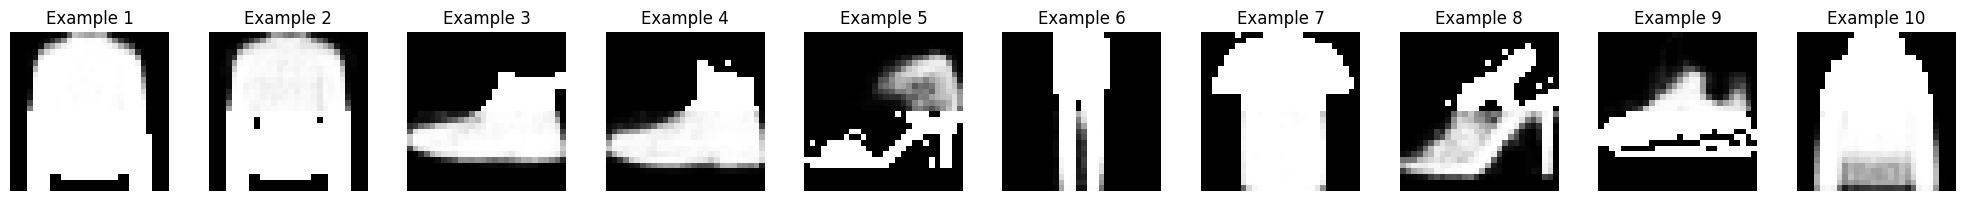

In [4]:
import matplotlib.pyplot as plt
import jax.numpy as jnp # Assuming the data is a JAX array

# The variable test_data_for_classifier_unmasked_plus_generated
# Assuming it's a JAX array where each row is a flattened image (e.g., 784 elements)

# Select a few examples to display (e.g., the first 5)
num_examples_to_show = 10
selected_digits = test_data_for_classifier_unmasked_plus_generated[:num_examples_to_show]

# Reshape the flattened images back to their original dimensions (e.g., 28x28 for MNIST)
# Assuming the original images were 28x28
image_height = 28
image_width = 28
reshaped_digits = selected_digits.reshape(num_examples_to_show, image_height, image_width)

# Plot the selected digits
plt.figure(figsize=(num_examples_to_show * 2, 2)) # Adjust figure size as needed
for i in range(num_examples_to_show):
    plt.subplot(1, num_examples_to_show, i + 1)
    # Ensure grayscale display by explicitly setting cmap and potentially normalization
    # Using 'gray' colormap and setting vmin/vmax if the data is in [0, 1] or similar range
    plt.imshow(reshaped_digits[i], cmap='gray', vmin=0, vmax=1) # Assuming data is scaled between 0 and 1
    plt.title(f'Example {i+1}')
    plt.axis('off') # Hide axes

plt.tight_layout()
plt.show()

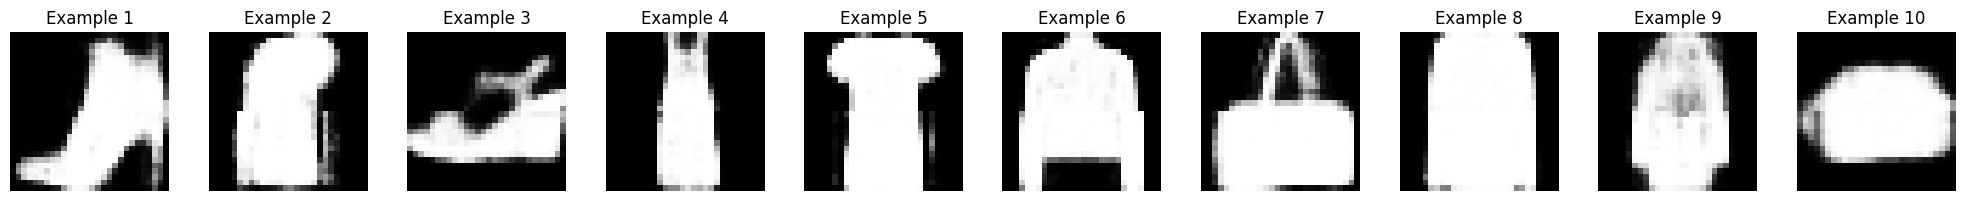

In [5]:
num_examples_to_show = 10

classifier_train_sample_images = jnp.concatenate([
          vae_full_train_res['rec_v1'][:num_examples_to_show].reshape(-1, 14,28, 1),
          vae_full_train_res['rec_v2'][:num_examples_to_show].reshape(-1, 14,28, 1)
      ], axis=1) # Concatenate horizontally to show top and bottom side-by-side

# Plot the selected digits
plt.figure(figsize=(num_examples_to_show * 2, 2)) # Adjust figure size as needed
for i in range(num_examples_to_show):
    plt.subplot(1, num_examples_to_show, i + 1)
    # Ensure grayscale display by explicitly setting cmap and potentially normalization
    # Using 'gray' colormap and setting vmin/vmax if the data is in [0, 1] or similar range
    plt.imshow(classifier_train_sample_images[i], cmap='gray', vmin=0, vmax=1) # Assuming data is scaled between 0 and 1
    plt.title(f'Example {i+1}')
    plt.axis('off') # Hide axes

plt.tight_layout()
plt.show()

In [6]:
full_train_labs[:num_examples_to_show]

Array([9, 6, 5, 3, 0, 2, 8, 2, 2, 8], dtype=int32)